<h1><center>Statistical Learning Homework 3</center></h1>
<h4><center>吴嘉骜 21307130203</center></h4>

# 一、案例：数据分析岗位招聘

## 1. 读入数据并完成简单的数据清洗

In [ ]:
library(readxl)
library(tidyverse)
mydata <- read_excel("Mydata.xlsx")

# 移除包含缺失值 (NA) 的行
mydata <- subset(mydata, !apply(mydata == "NA", 1, any))

## 2. 提取出频次最高的5个行业类别，绘制出直方图

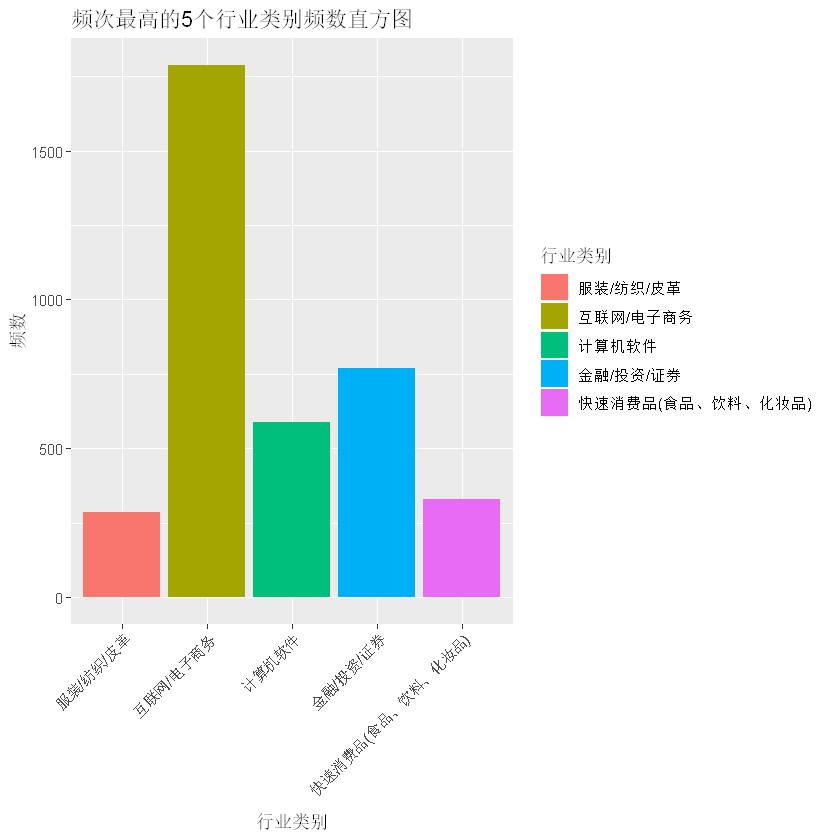

In [2]:
top_industries <- head(arrange(count(mydata, 行业类别), -n), 5)

# 绘制直方图
ggplot(top_industries, aes(x = 行业类别, y = n, fill = 行业类别)) +
    geom_col() +
    labs(title = "频次最高的5个行业类别频数直方图", x = "行业类别", y = "频数") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))


解读：从以上频数直方图可以看出，互联网/电子商务行业的数据分析岗位需求最多，远超其他行业，需求数占全部行业类别将近1/3；其次是金融/投资/证券行业，后面依次是计算机软件、快消品和服装/纺织/皮革行业，他们之间的差距并没有前两名之间的大。

## 3. 除去频次最高的5个行业类别，绘制词云图

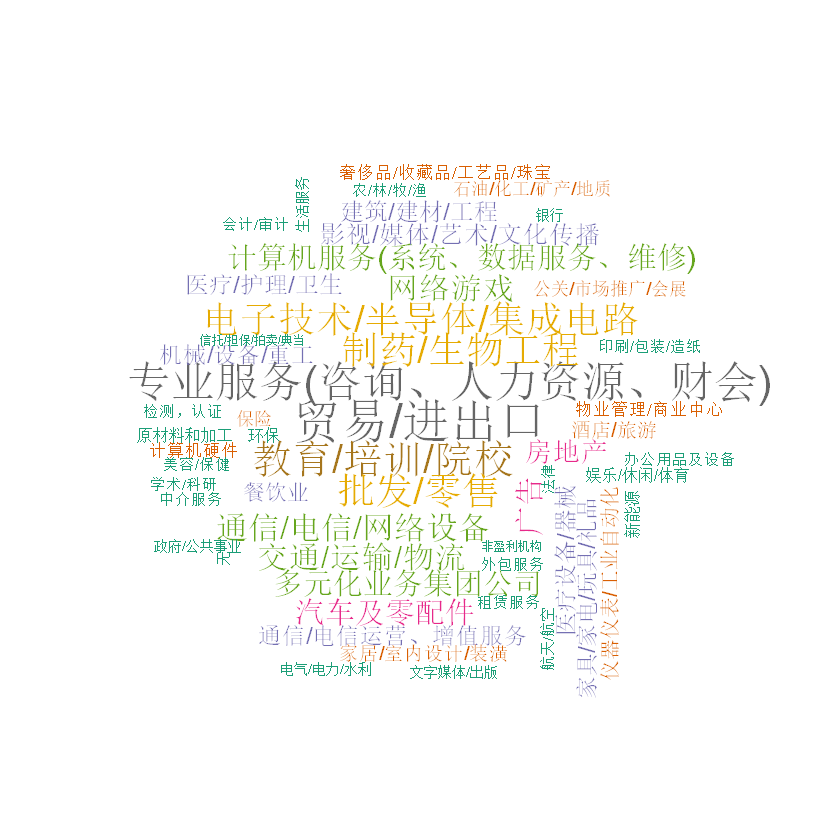

In [43]:
library(wordcloud)

# 从数据中排除top 5行业
other_industries <- subset(mydata, !(行业类别 %in% top_industries$行业类别))

# 获取其他行业的频次
industry_freq <- table(other_industries$行业类别)

# 绘制词云图
wordcloud(names(industry_freq), industry_freq, random.order = FALSE, colors = brewer.pal(8, "Dark2"), scale=c(2.4, 0.6))

## 4. 以对数平均薪资为对象，进行简单的描述分析

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.55   12.36   12.77   12.93   13.55   18.61 

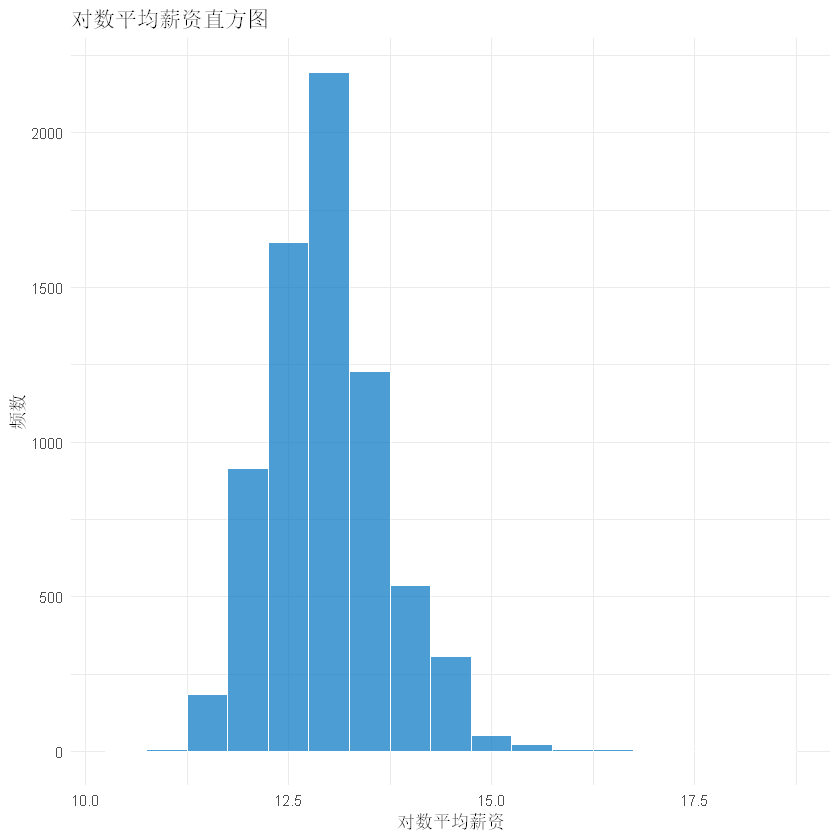

In [4]:
# 将数据转化为数值型
mydata$最高薪资 <- as.numeric(mydata$最高薪资)
mydata$最低薪资 <- as.numeric(mydata$最低薪资)

mydata$avg_salary <- (mydata$最高薪资 + mydata$最低薪资) / 2
mydata$log_avg_salary <- log(mydata$avg_salary, base = 2)
summary(mydata$log_avg_salary)

# 绘制直方图
ggplot(mydata, aes(x = log_avg_salary)) +
    geom_histogram(binwidth = 0.5, fill = "#0073C2", color = "white", alpha = 0.7) +
    labs(title = "对数平均薪资直方图", x = "对数平均薪资", y = "频数") +
    theme_minimal()

以2为底对数平均薪资的均值是12.93，最小值是10.55，最大值是18.61，中位数是12.77，这说明数据分析岗位的薪资水平集中在5000~10000元之间，由直方图可见薪资水平的分布呈现右偏，只有少部分岗位的薪资水平较高。

## 5. 使用箱线图，探究学历对岗位薪资的影响

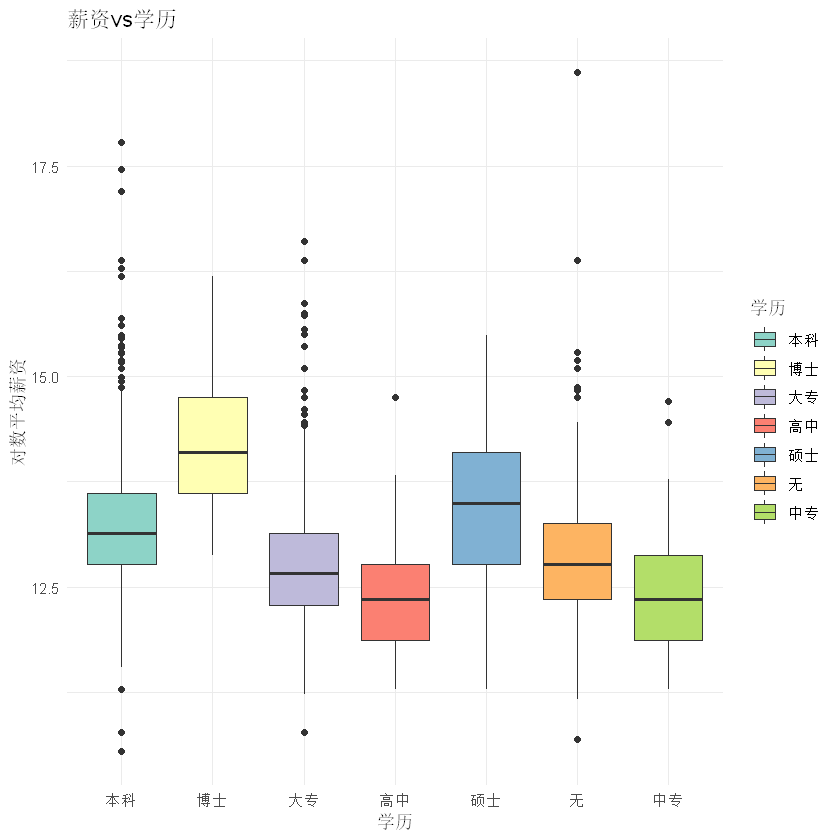

In [5]:
# 绘制箱线图
ggplot(mydata, aes(x = 学历, y = log_avg_salary, fill = 学历)) +
    geom_boxplot() +
    labs(title = "薪资vs学历", x = "学历", y = "对数平均薪资") +
    theme_minimal() +
    scale_fill_brewer(palette = "Set3")

由箱线图可见，学历对岗位薪资存在一定的影响。随着学历要求的提高，岗位薪资的中位数和上、下四分位数都有所提高。而且学历要求越高（硕士、博士），最高和最低薪资的差距越大，分布也更加分散。

对于本科、大专和无要求的学历，出现了较多的异常值，这说明这些学历的岗位薪资分布情况比较极端，存在相当高薪资的岗位。而高中和中专学历的岗位薪资分布较为集中，水平相对较低。

## 6. 提取岗位描述中对软件的要求，并使用箱线图展示

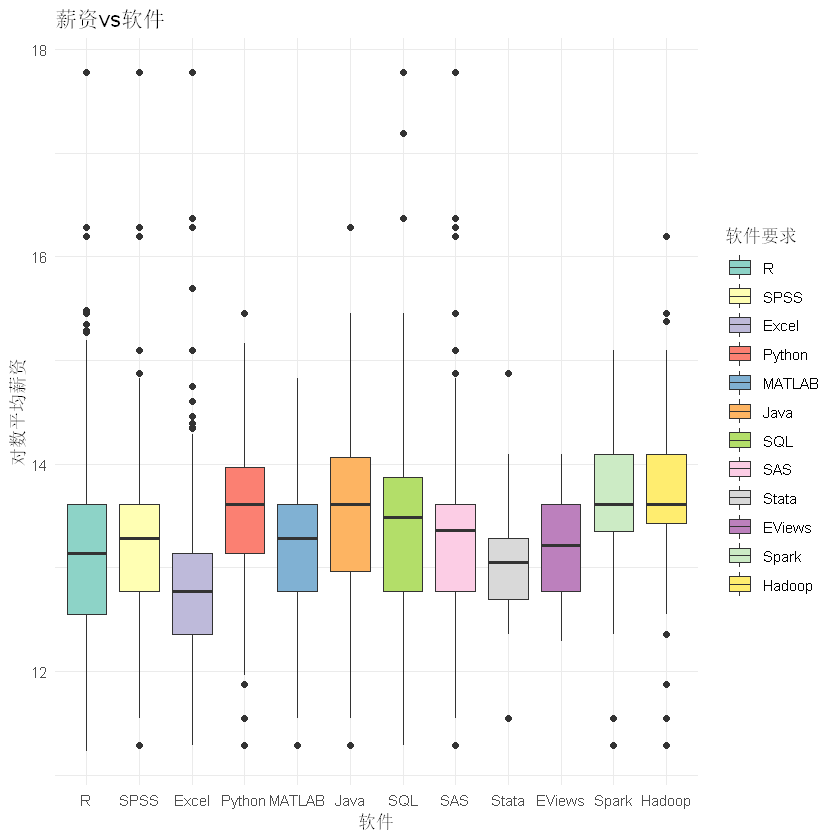

In [12]:
software <- c("R", "SPSS", "Excel", "Python", "MATLAB", "Java", "SQL", "SAS", "Stata", "EViews", "Spark", "Hadoop")

# 为每个软件创建一个新的列
for (s in software) {
    mydata[[s]] <- ifelse(grepl(s, mydata$描述, ignore.case = TRUE), 1, 0)
}

# 将数据转化为长格式
software_melt <- reshape2::melt(mydata, id.vars = "log_avg_salary", measure.vars = software)

# 绘制箱线图
ggplot(software_melt[software_melt$value == 1, ], aes(x = variable, y = log_avg_salary, fill = variable)) +
    geom_boxplot() +
    labs(title = "薪资vs软件", x = "软件", y = "对数平均薪资", fill='软件要求') +
        theme_minimal() +
        scale_fill_brewer(palette = "Set3")

由箱线图可见，软件要求对岗位薪资也有一定的影响。对Python, Java, SQL, Spark和Hadoop有要求的岗位，薪资水平的中位数和上、下四分位数较高；而对Excel, Stata有要求的岗位薪资水平的对应值则较低。这可能是由于前面的软件学习难度更大，且熟练掌握后对数据分析工作帮助更大，且能力要求更高，所以薪资水平更高。

要求R, Java, SQL的岗位薪资分布较为分散，要求Stata的岗位薪资分布较为集中。对R, Excel和SAS有要求的岗位薪资出现了较多的异常值，表明也无法排除有这些软件要求的岗位薪资水平较高的情况。

## 7. 按要求建立线性回归模型


Call:
lm(formula = log_avg_salary ~ ., data = model_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4573 -0.4202 -0.0734  0.3501  5.8199 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          12.859237   0.046802 274.760  < 2e-16 ***
地区北京             -0.023234   0.022966  -1.012  0.31174    
地区深圳             -0.000297   0.019355  -0.015  0.98776    
地区陕西             -0.533841   0.030968 -17.239  < 2e-16 ***
地区山西             -0.497710   0.046565 -10.689  < 2e-16 ***
地区河北             -0.614680   0.029422 -20.892  < 2e-16 ***
公司类别民营公司      0.055759   0.041069   1.358  0.17460    
公司类别上市公司      0.153208   0.051169   2.994  0.00276 ** 
公司类别外资          0.061727   0.045503   1.357  0.17497    
公司类别非营利机构   -0.068822   0.153797  -0.447  0.65454    
公司类别合资          0.130498   0.045935   2.841  0.00451 ** 
公司类别事业单位     -0.164867   0.167547  -0.984  0.32515    
公司类别创业公司      0.180778   0.077777   2.324  0.02014 *  
公司规模少于50人     -0.044664

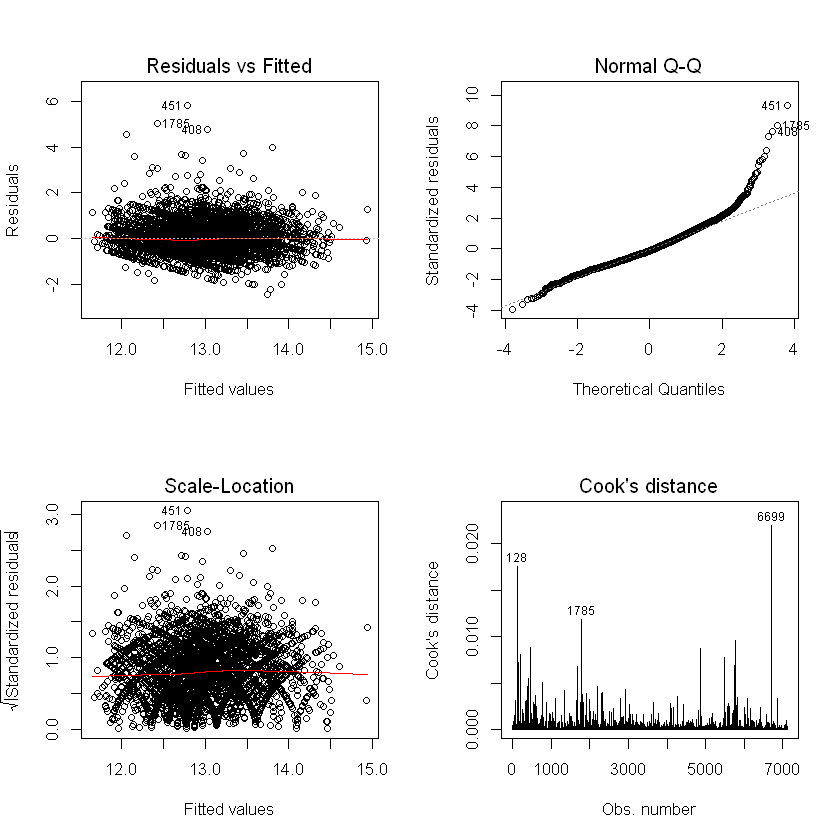

In [7]:
# 设置地区的基准类别为“上海”
mydata$地区 <- factor(mydata$地区, levels = c("上海", "北京", "深圳", "陕西", "山西", "河北"))

# 设置公司类别的基准类别为“国企”
mydata$公司类别 <- factor(mydata$公司类别, levels = c("国企", "民营公司", "上市公司", "外资", "非营利机构", "合资", "事业单位", "创业公司"))

# 设置公司规模的基准类别为“500-1000人”
mydata$公司规模 <- factor(mydata$公司规模, levels = c("500-1000人", "少于50人", "50-150人", "150-500人", "1000-5000人", "5000-10000人", "10000人以上"))

# 设置学历的基准类别为“本科”
mydata$学历 <- factor(mydata$学历, levels = c("本科", "无", "高中", "中专", "大专", "硕士", "博士"))

model_data <- select(mydata, log_avg_salary, 地区, 公司类别, 公司规模, 经验, 学历, software)

# 建立线性回归模型
model <- lm(log_avg_salary ~ ., data = model_data)
summary(model)
# 绘制回归诊断图
par(mfrow = c(2, 2))
plot(model,which=c(1:4))

在控制其他因素不变时，数据分析岗位的影响因素有如下特征：
- 地区：上海的岗位薪资水平最高，但北京、深圳和上海薪资相近，没有显著差异；而河北、山西和陕西地区的薪资都显著较低，其中河北最低。
- 公司类别：以国企作为基准，并没有十分显著的差异，上市公司、创业公司的岗位薪资水平最高，而事业单位的薪资水平最低。
- 公司规模：以“500-1000人”作为基准，也没有显著的差异，大体上呈现规模由小到“150-500人”薪资水平逐渐提高，此后再逐渐降低的趋势。
- 学历：与基准“本科”相比，要求“大专”、“高中”、“中专”学历的薪资都显著较低，而要求“博士”和“硕士”学历的薪资显著较高。
- 经验要求：薪资与经验要求呈现正相关，经验每增加一年，对数平均薪资预计增加约0.142。
- 软件要求：要求熟悉R、Python、SQL、SAS和Hadoop的岗位薪资显著较高，而要求Excel的薪资显著较低。

从诊断图可以看出，残差与拟合值的关系基本呈现线性关系，模型的残差分布在两端偏离正态性，残差具有相对恒定的方差，大多数的数据点都有很小的Cook's距离。这说明模型大致满足线性回归的假设，但有些细节之处可能还要处理。

## 8. 使用第7问得到的模型，进行模型预测准确度评估

In [8]:
# 定义交叉验证函数
pred_k <- function(dat, k) {
    ind <- sample(1:k, nrow(dat), replace = T)
    pred_cv <- rep(0, nrow(dat))
    for (i in 1:k) {
        ii <- which(ind == i)
        obj <- lm(log_avg_salary ~ ., data = dat[-ii, ])
        pred_cv[ii] <- predict(obj, dat[ii, ])
    }
    rmse <- sqrt(mean((pred_cv - dat$log_avg_salary)^2))
    return(rmse)
}

set.seed(1234)
rmses = rep(0, 50)
# 重复50次交叉验证
for (i in 1:50) {
    rmses[i] <- pred_k(model_data, 5)
}

mean(rmses)

[1] 0.6282684

在对数薪资的尺度上，模型的预测平均误差为0.628。

# 二、逻辑回归  Newton-Raphson算法实现

## 1. 获得逻辑回归函数的梯度和海森矩阵

Let $p(x_i;\beta) = P(Y=1|X=x_i) = \frac{exp(x_i^{\top}\beta)}{1+exp(x_i^{\top}\beta)}$.

The maximum likelihood function is

$$f(\beta) = \prod\limits_{i=1}^N p(x_i;\beta)^{y_i}(1-p(x_i;\beta))^{1-y_i}$$

The log-likelihood function is

$$l(\beta) = \sum\limits_{i=1}^N y_i\log p(x_i;\beta) + (1-y_i)\log(1-p(x_i;\beta)) = \sum\limits_{i=1}^N y_ix_i^{\top}\beta - \log(1+exp(x_i^{\top}\beta))$$

The gradient of $l(\beta)$ is
$$\nabla l(\beta) = \sum\limits_{i=1}^N y_ix_i - \frac{exp(x_i^{\top}\beta)}{1+exp(x_i^{\top}\beta)}x_i = \sum\limits_{i=1}^N (y_i - p(x_i;\beta))x_i$$

To calculate the Hessian matrix, we rewrite the above formula in matrix form.

Let $Y=[y_1,\ldots,y_N]^{\top}, X = [x_1,\ldots,x_N]^{\top}, P(\beta) = [p(x_1;\beta),\ldots,p(x_N;\beta)]^{\top} = e-\frac{1}{1+exp(X\beta)}$, where $e$ is an all-1 $N\times 1$ vector.

Then the gradient of $l(\beta)$ can be written as $\nabla l(\beta) = X^{\top}(Y-P(\beta))$.

Let's calculate the Jacobian matrix (derivative) of $\nabla l(\beta)$:

$D(\nabla l(\beta)$) = $D(X^{\top}(Y-P(\beta)))$ = $-X^{\top}D(P(\beta)) = X^{\top}D(\frac{1}{1+exp(X\beta)})$.

From the chain rule, we have $D(\frac{1}{1+exp(X\beta)}) = -diag\{\frac{exp(x_i^{\top}\beta)}{(1+exp(x_i^{\top}\beta))^2}\}X = -diag(p(x_i;\beta)(1-p(x_i;\beta)))X =: -WX$.

The Hessian matrix of $l(\beta)$ is
$$\nabla^2 l(\beta) = -X^{\top}WX = -\sum\limits_{i=1}^N p(x_i;\beta)(1-p(x_i;\beta))x_ix_i^{\top}$$

## 2. 实现Newton-Raphson算法

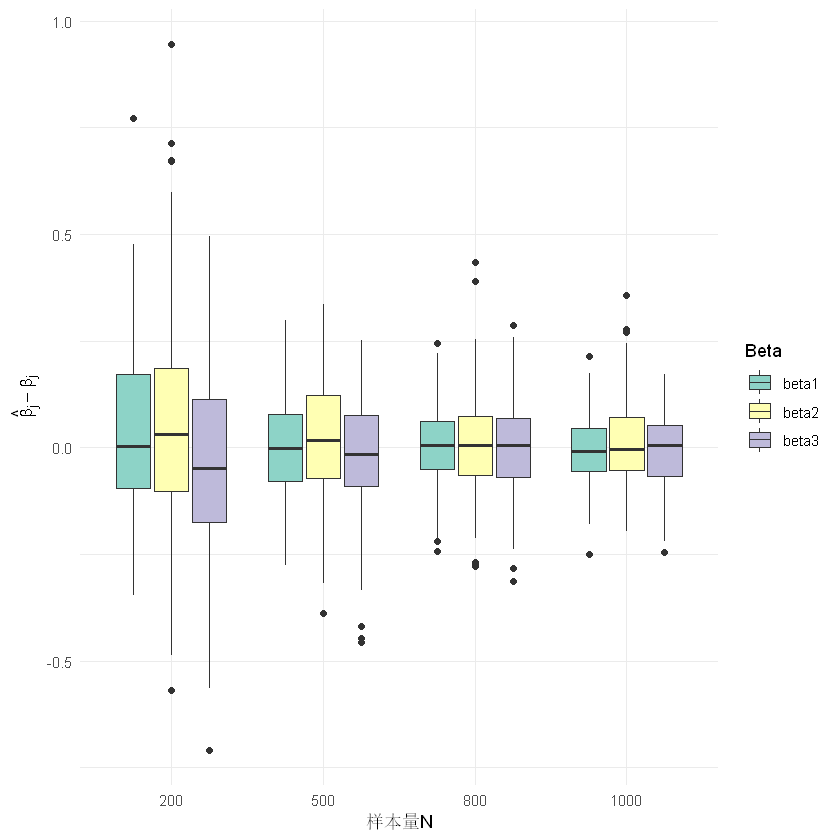

In [10]:
library(ggplot2)

# 1. 定义逻辑回归函数及其导数
logistic <- function(z) {
  return(1 / (1 + exp(z)))
}

# 2. 定义Newton-Raphson算法
newton_raphson <- function(X, y, tol = 1e-5, max_iter = 100) {
  n <- nrow(X)
  p <- ncol(X)

  beta <- matrix(0, p, 1) # 初始化beta
  iter <- 1
  converge <- FALSE

  while (iter <= max_iter && !converge) {
    eta <- X %*% beta
    mu <- logistic(eta)
    W <- diag(as.vector(mu * (1 - mu)))
    z <- eta + (y - 1 + mu) / (mu * (1 - mu))

    beta_new <- solve(t(X) %*% W %*% X) %*% t(X) %*% W %*% z
    if (max(abs(beta - beta_new)) < tol) {
      converge <- TRUE
    } else {
      beta <- beta_new
    }

    iter <- iter + 1
  }
  return(beta)
}

# 3. 模拟数据
simulate_data <- function(N, beta) {
  X <- matrix(rnorm(N * 2), N, 2)
  X <- cbind(1, X)

  prob <- logistic(X %*% beta)
  y <- rbinom(N, 1, 1 - prob)

  list(X = X, y = y)
}

# 真实Beta值
beta_true <- matrix(c(0.5, 1.2, -1), 3, 1)

# 4. 运行算法
Ns <- c(200, 500, 800, 1000)
R <- 200
results <- list()

for (N in Ns) {
  beta_hats <- matrix(0, 3, R)

  for (r in 1:R) {
    data <- simulate_data(N, beta_true)
    beta_hat <- newton_raphson(data$X, data$y)
    beta_hats[, r] <- beta_hat
  }
  results[[as.character(N)]] <- beta_hats
}

# 5. 绘制箱线图
df <- data.frame()

for (N in Ns) {
  diffs <- sweep(results[[as.character(N)]], 1, as.vector(beta_true), "-")
  tmp_df <- as.data.frame(t(diffs))
  tmp_df$N <- N
  df <- rbind(df, tmp_df)
}

colnames(df) <- c("beta1", "beta2", "beta3", "N")
df_long <- reshape2::melt(df, id.vars = "N")

ggplot(df_long, aes(x = factor(N), y = value, fill = variable)) +
  geom_boxplot() +
  labs(y = expression(hat(beta)[j] - beta[j]),
      x = "样本量N",
      fill = "Beta") +
  theme_minimal() +
    scale_fill_brewer(palette = "Set3")